# Mapping subtypes to clusters using drivers (Figure 3)

In [1]:
from __future__ import division
import sys
import random
import copy
import math
import json

import numpy as np
import pandas as pd
import scipy

%matplotlib inline
from matplotlib import pyplot as plt
import matplotlib as mpl

import seaborn as sns

sys.path.append("../resources/")
import sct
reload(sct)

sns.set_style("ticks")
sns.set_context("talk")

output_dir = "out/"
output_suffix = ""
output_formats = [".png", ".pdf"]

def save_figure(fig, name):
    for output_format in output_formats:
        fig.savefig(output_dir + "/" + name + output_suffix + output_format)
    return None

mpl.rc('savefig', dpi=300)

pd.options.mode.chained_assignment = None  # default='warn'

# Load data

In [2]:
df_logCPM_all = pd.read_csv("../data/htseq_logCPM_hq.tab.gz", sep="\t", header=0, index_col=0) # CPM
df_libs = pd.read_csv("../data/libs.csv", sep=",", header=0, index_col=0) # sample info

# Filter for cells in Figure 3 (GH146, Mz19, 91G04)

In [4]:
# Load names of high quality neurons (4/5 markers)
names_hq_neurons = []
with open("../data/names_hq_neurons.txt") as f:
    for line in f:
        names_hq_neurons.append(line.rstrip())
        
# Load names of contaminating neurons (vPN, APL)
names_vPN = []
with open("../data/names_vPN.txt") as f:
    for line in f:
        names_vPN.append(line.rstrip())
        
names_APL = []
with open("../data/names_APL.txt") as f:
    for line in f:
        names_APL.append(line.rstrip())

# Get names of neurons, astrocytes
selector = (((df_libs["genotype"] == "GH146-GFP") |
             (df_libs["label"] == "Mz19-GFP,24hAPF") |
             (df_libs["genotype"] == "91G04-GFP")) &
            (df_libs["num_cells"] == 1))
names_genotypes = [x for x in list(df_logCPM_all.columns) if x in df_libs.loc[selector].index and
                                                             x in names_hq_neurons and 
                                                             x not in names_vPN and 
                                                             x not in names_APL]
print "Neurons of correct genotypes", len(names_genotypes)

# Filter for these cells
df = df_logCPM_all[list(names_genotypes)]
print "Number of cells", len(names_genotypes)

# Display number of cells of each genotype
df_libs.loc[df.columns]["genotype"].value_counts()

Neurons of correct genotypes 1048
Number of cells 1048


GH146-GFP    902
Mz19-GFP     123
91G04-GFP     23
Name: genotype, dtype: int64

# Load genes found by ICIM

In [5]:
genes_GH146_ICIM = []
with open("../data/genes_GH146_ICIM.txt") as f:
    for line in f:
        genes_GH146_ICIM.append(line.rstrip())

# Display cells using ICIM/TSNE

In [6]:
# Subset data to genes desired
Y = df.loc[genes_GH146_ICIM]

# Calculate TSNE
reload(sct)
from sklearn.manifold import TSNE
myTSNE = sct.TSNE(Y, df, df_libs)
myTSNE.calc_TSNE(perplexity=15, learning_rate=1000, random_state=1)

[t-SNE] Computing 46 nearest neighbors...
[t-SNE] Computed conditional probabilities for sample 1000 / 1048
[t-SNE] Computed conditional probabilities for sample 1048 / 1048
[t-SNE] Mean sigma: 0.142753
[t-SNE] Iteration 25: error = 1.7218348, gradient norm = 0.0275398
[t-SNE] Iteration 50: error = 1.6754010, gradient norm = 0.0257063
[t-SNE] Iteration 75: error = 1.1730173, gradient norm = 0.0190813
[t-SNE] Iteration 100: error = 1.1716654, gradient norm = 0.0172176
[t-SNE] Error after 100 iterations with early exaggeration: 1.171665
[t-SNE] Iteration 125: error = 0.9898680, gradient norm = 0.0147708
[t-SNE] Iteration 150: error = 1.0414760, gradient norm = 0.0157981
[t-SNE] Iteration 175: error = 1.0873286, gradient norm = 0.0153198
[t-SNE] Iteration 175: did not make any progress during the last 30 episodes. Finished.
[t-SNE] Error after 175 iterations: 1.087329


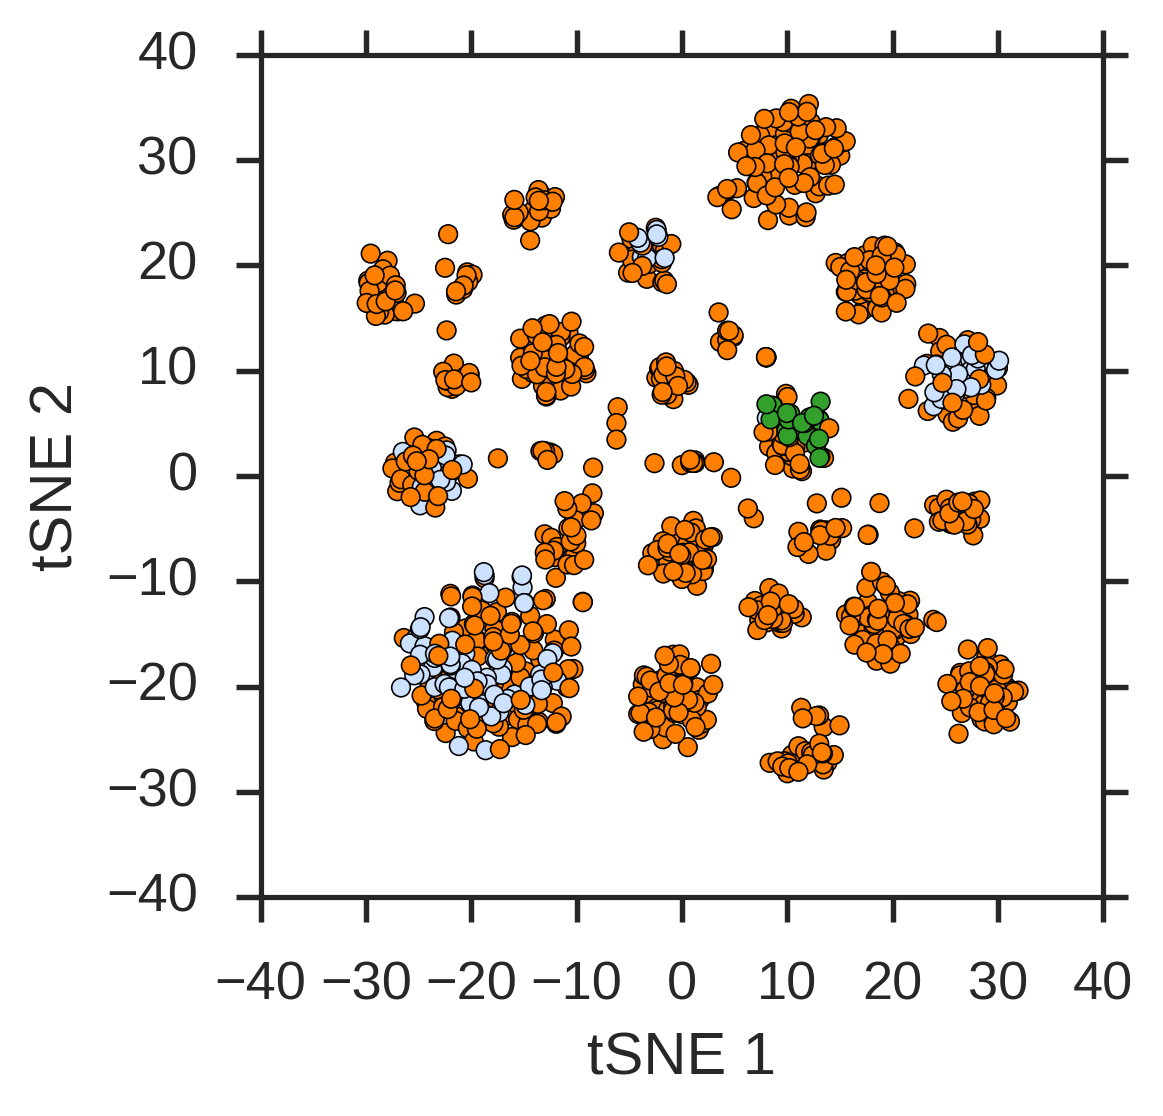

In [7]:
# Plot TSNE
fig, ax = plt.subplots(1, 1, figsize=(6,4))
myTSNE.plot(fig, ax, colorMode="genotype")
# save_figure(fig, "MappingKnownGenotypesIntoGH146_ICIM_TSNE")

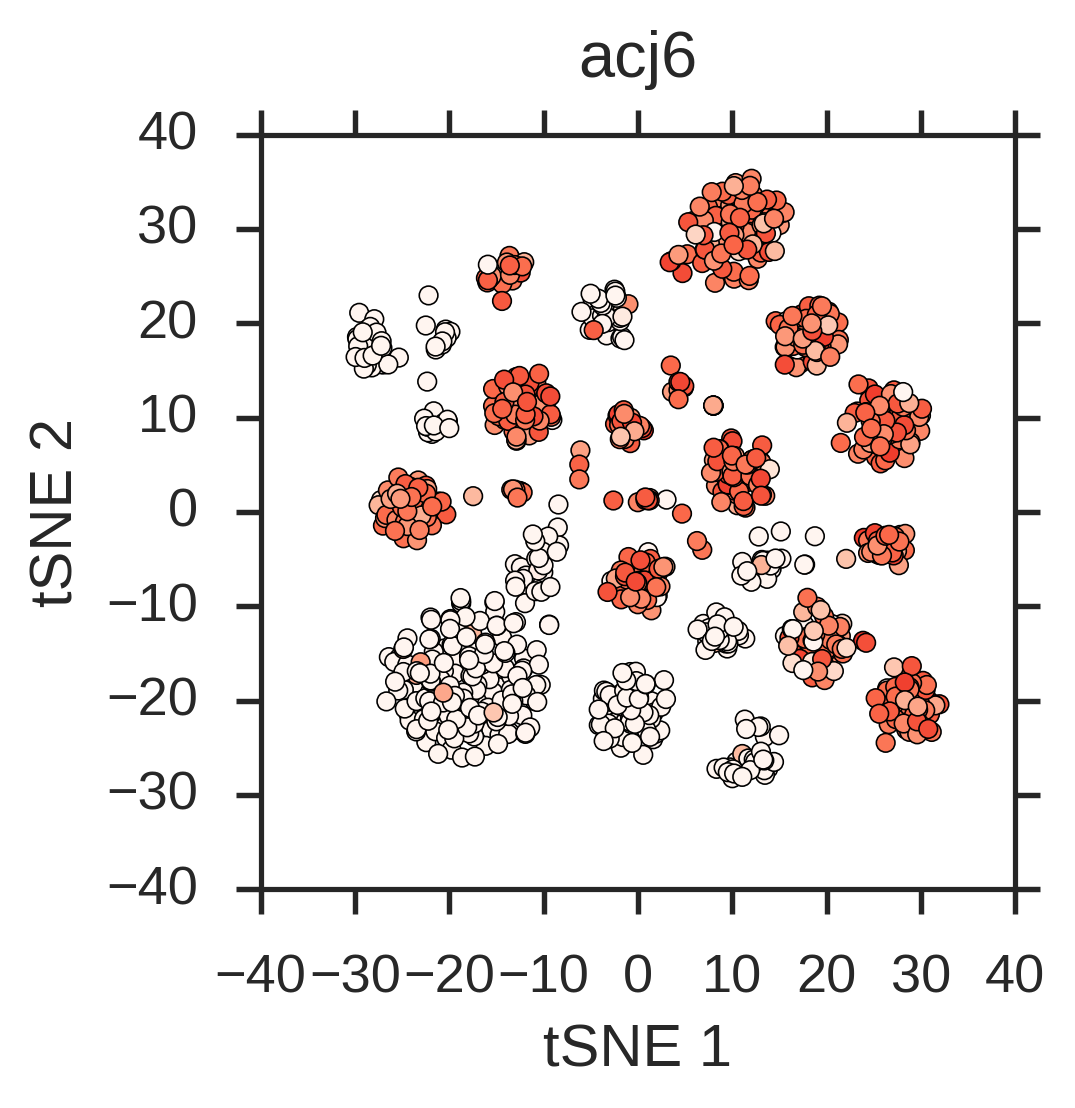

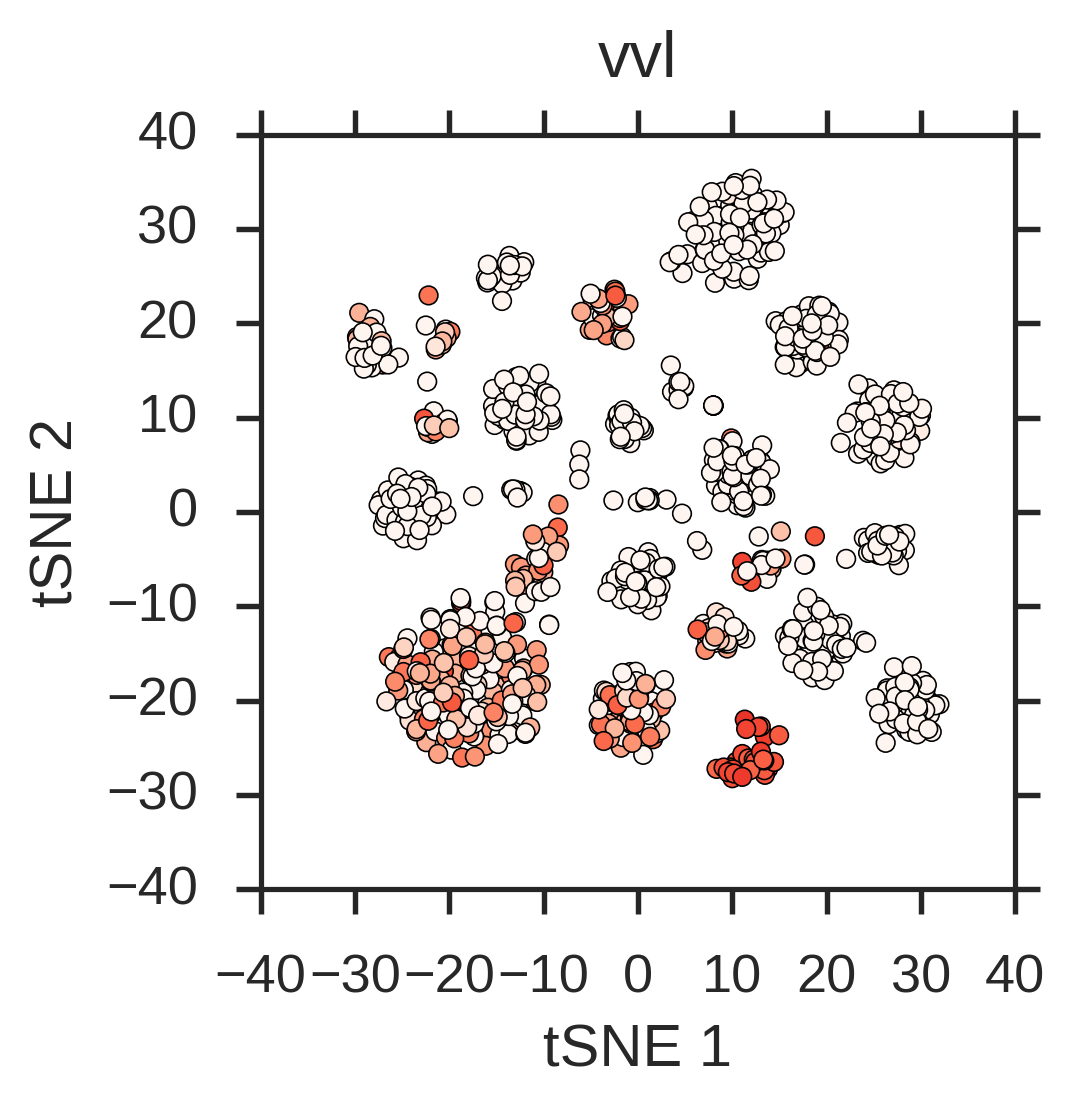

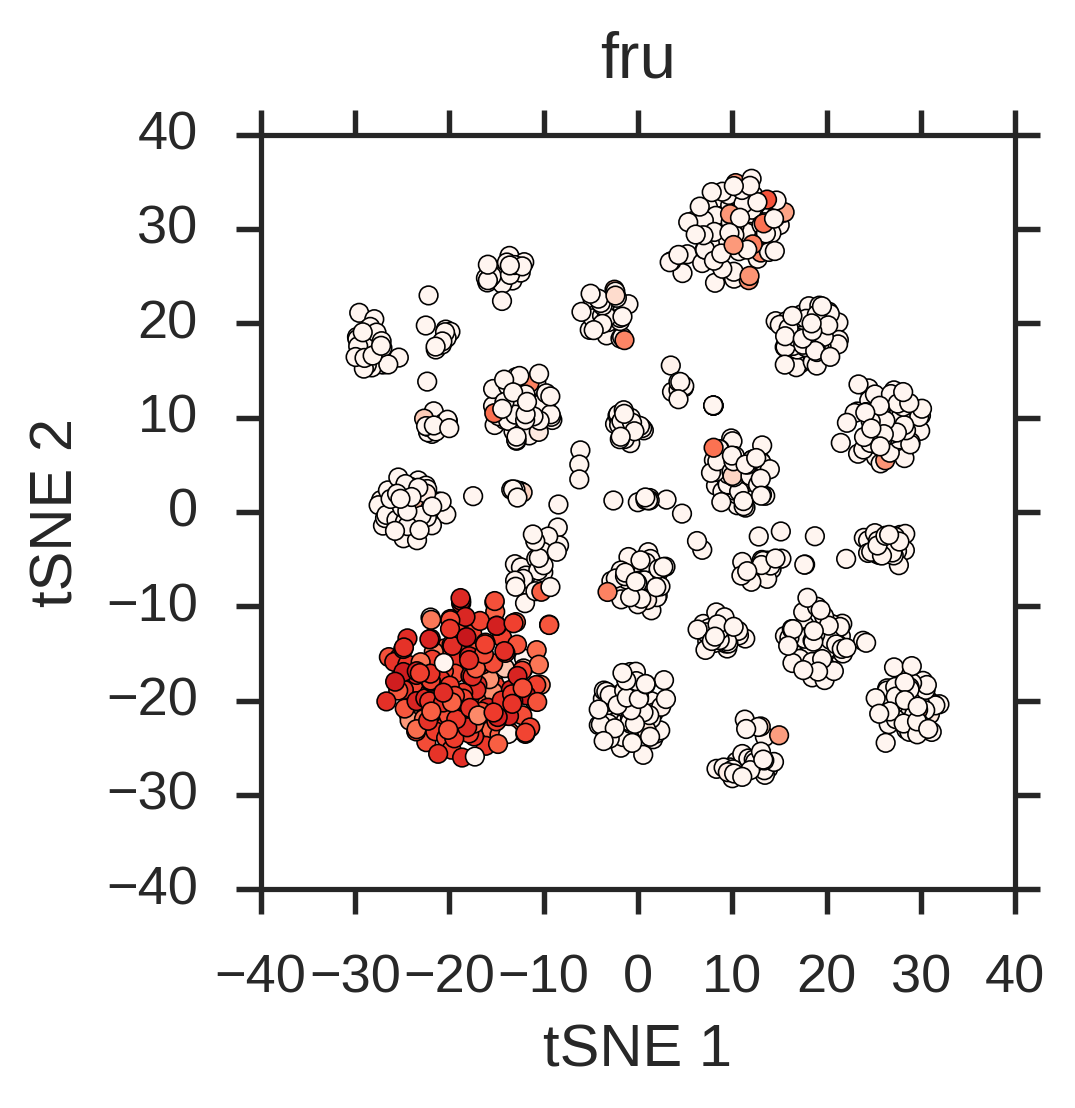

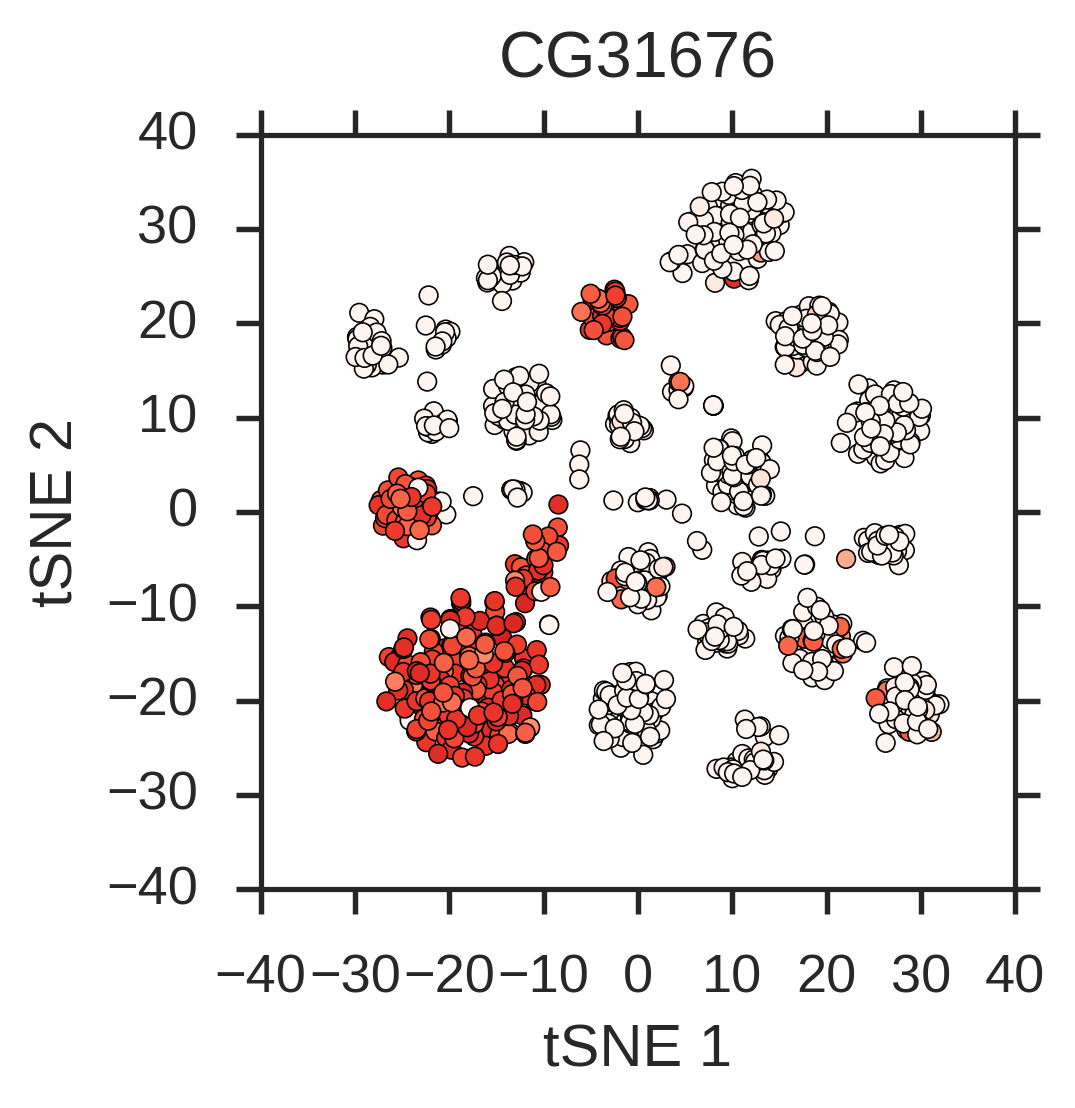

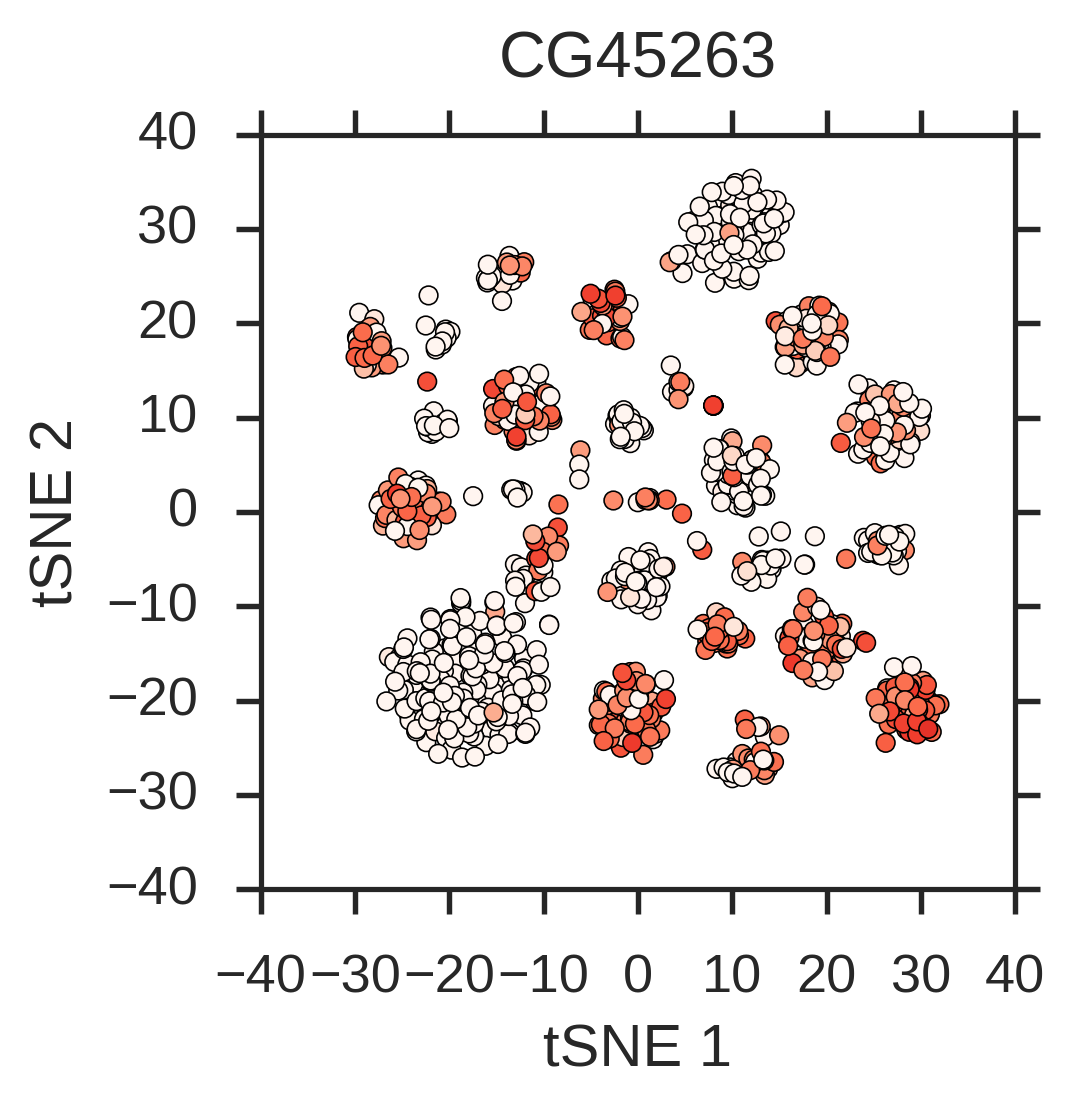

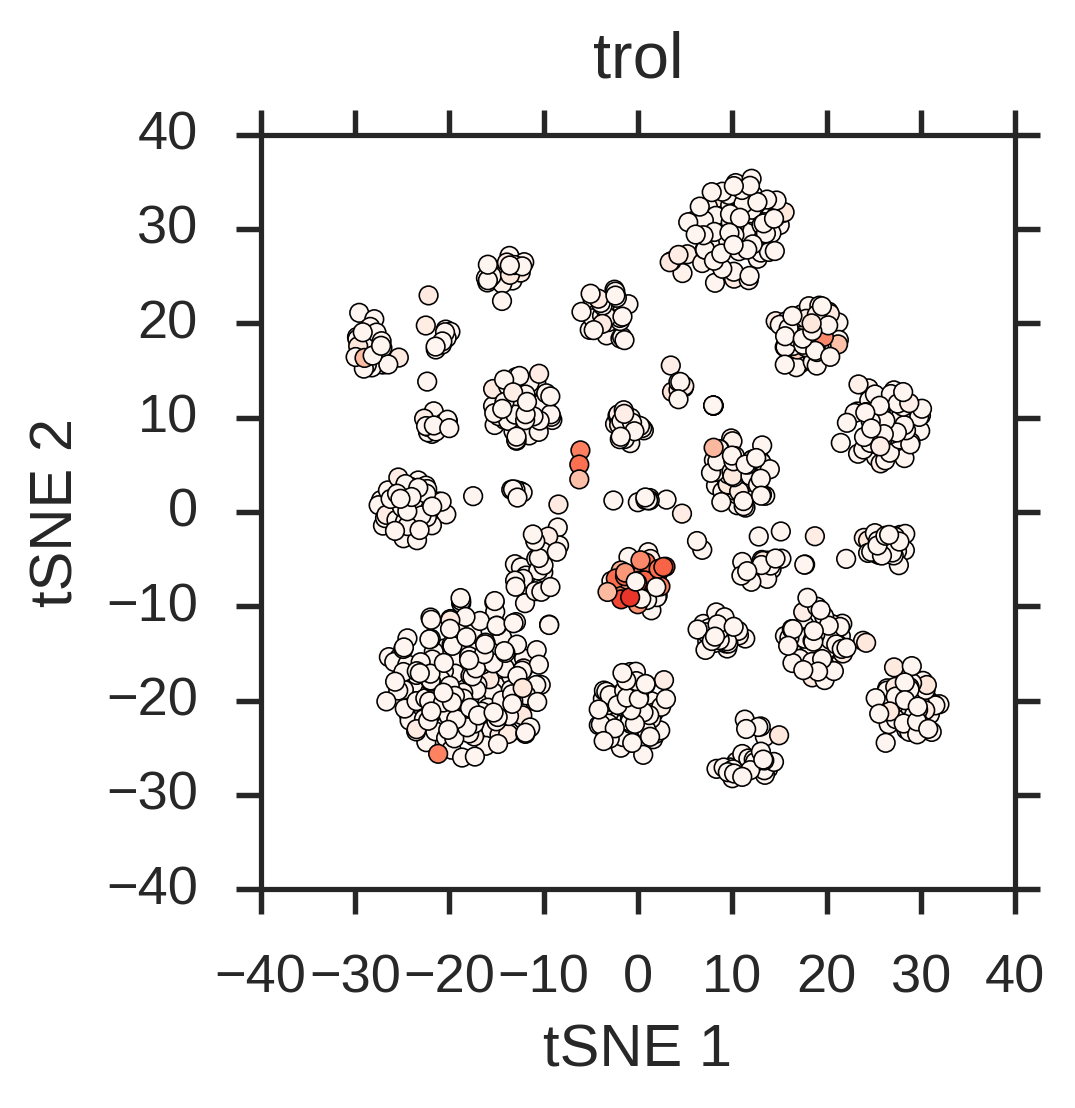

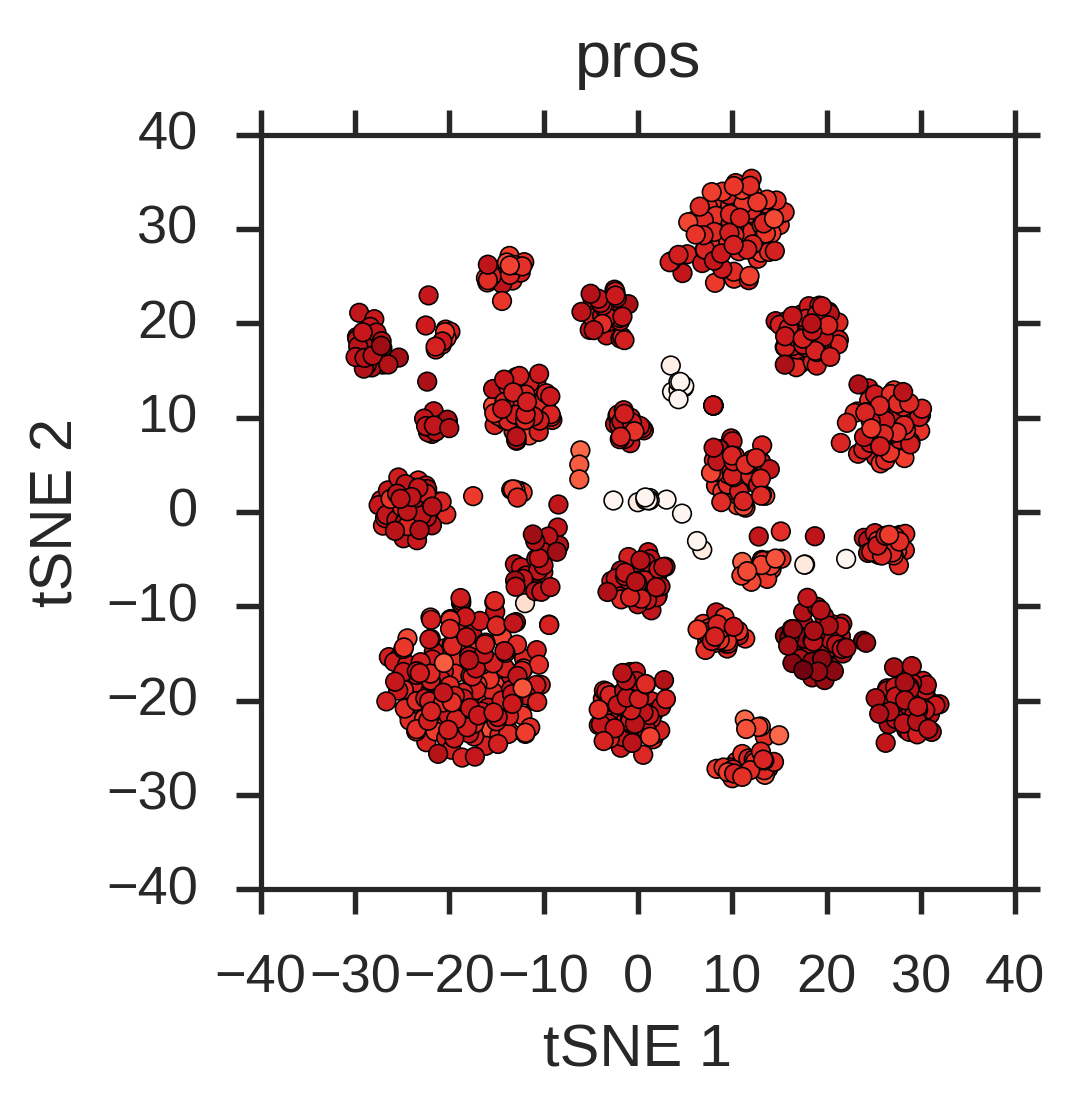

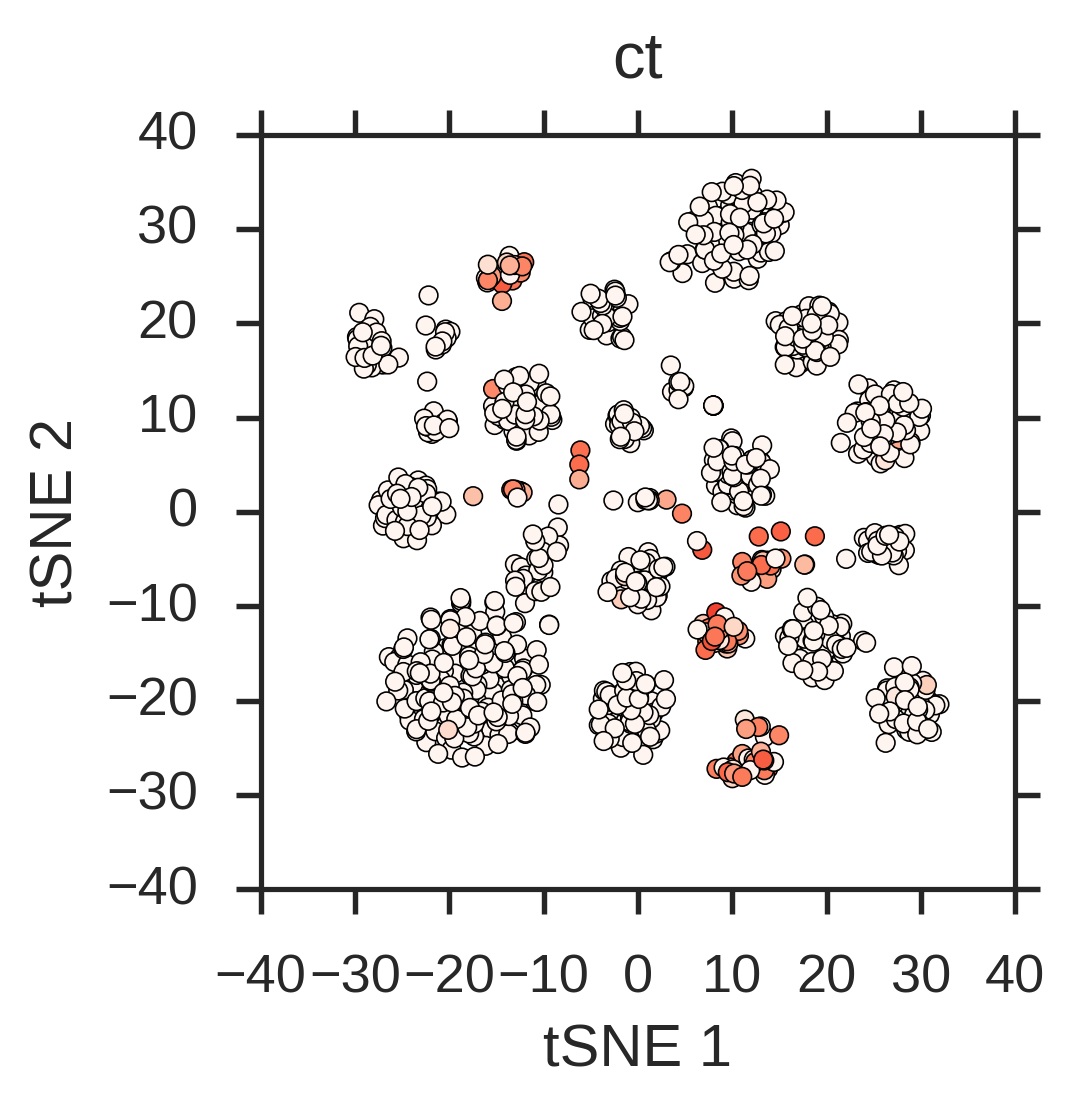

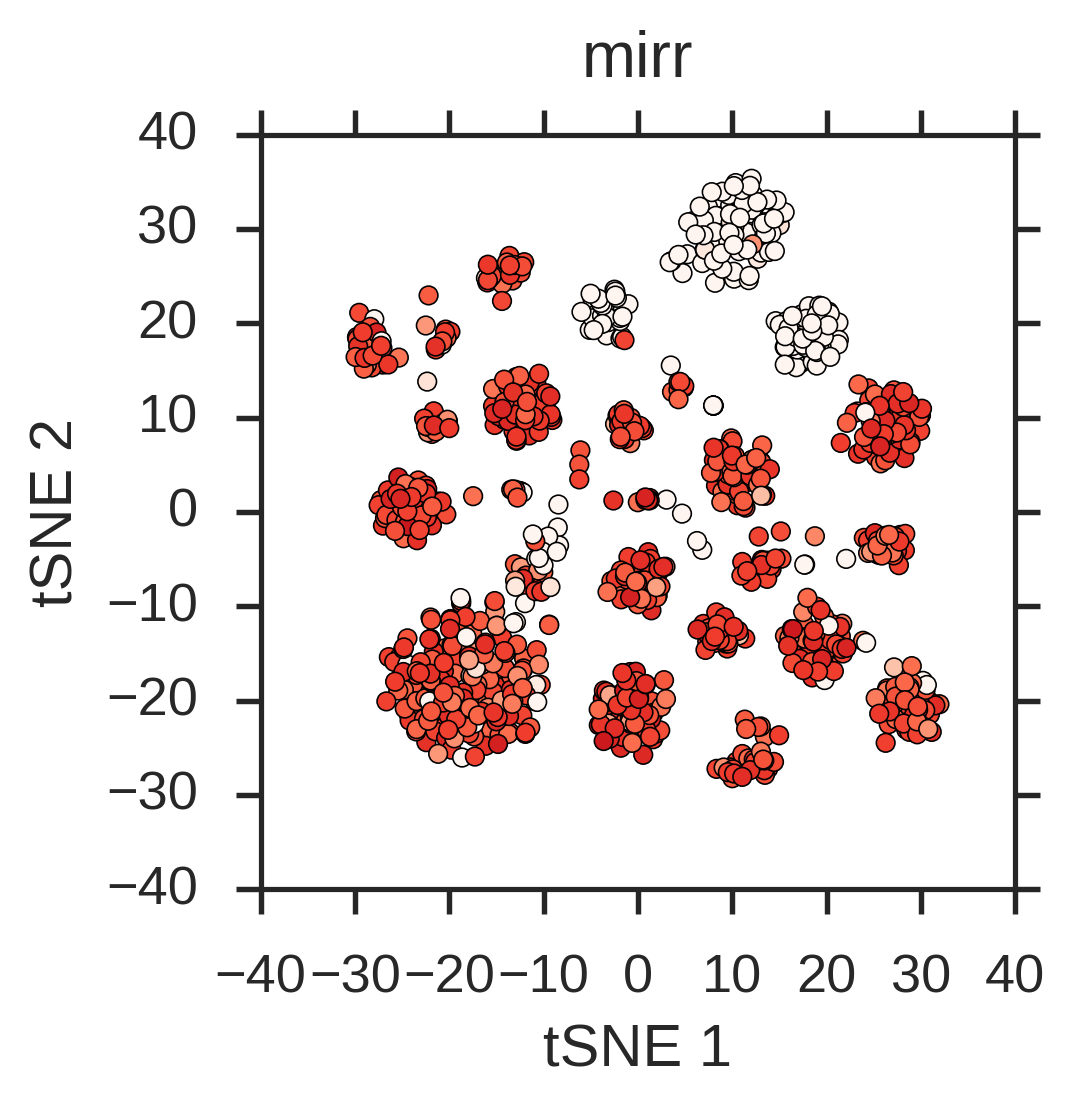

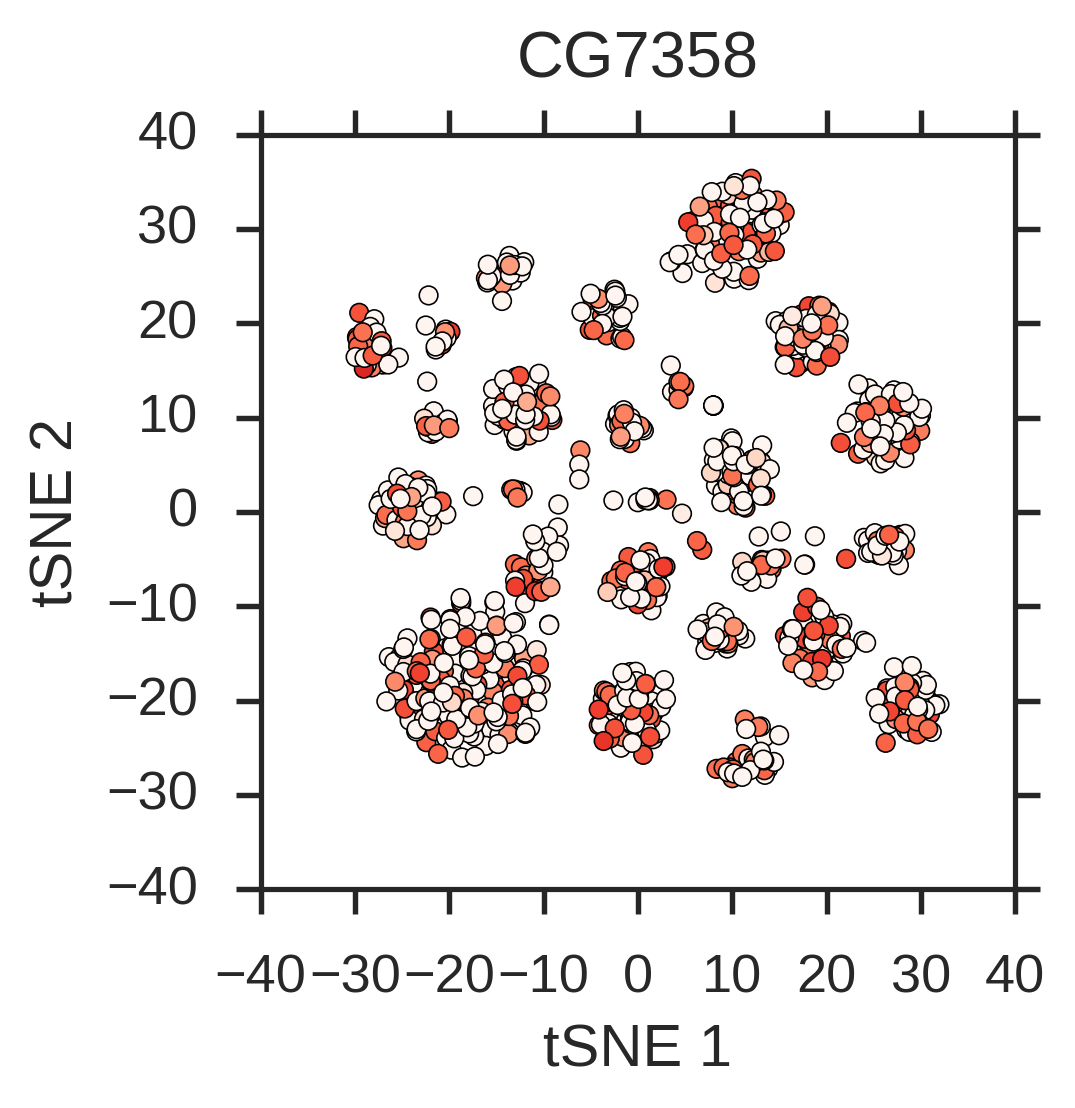

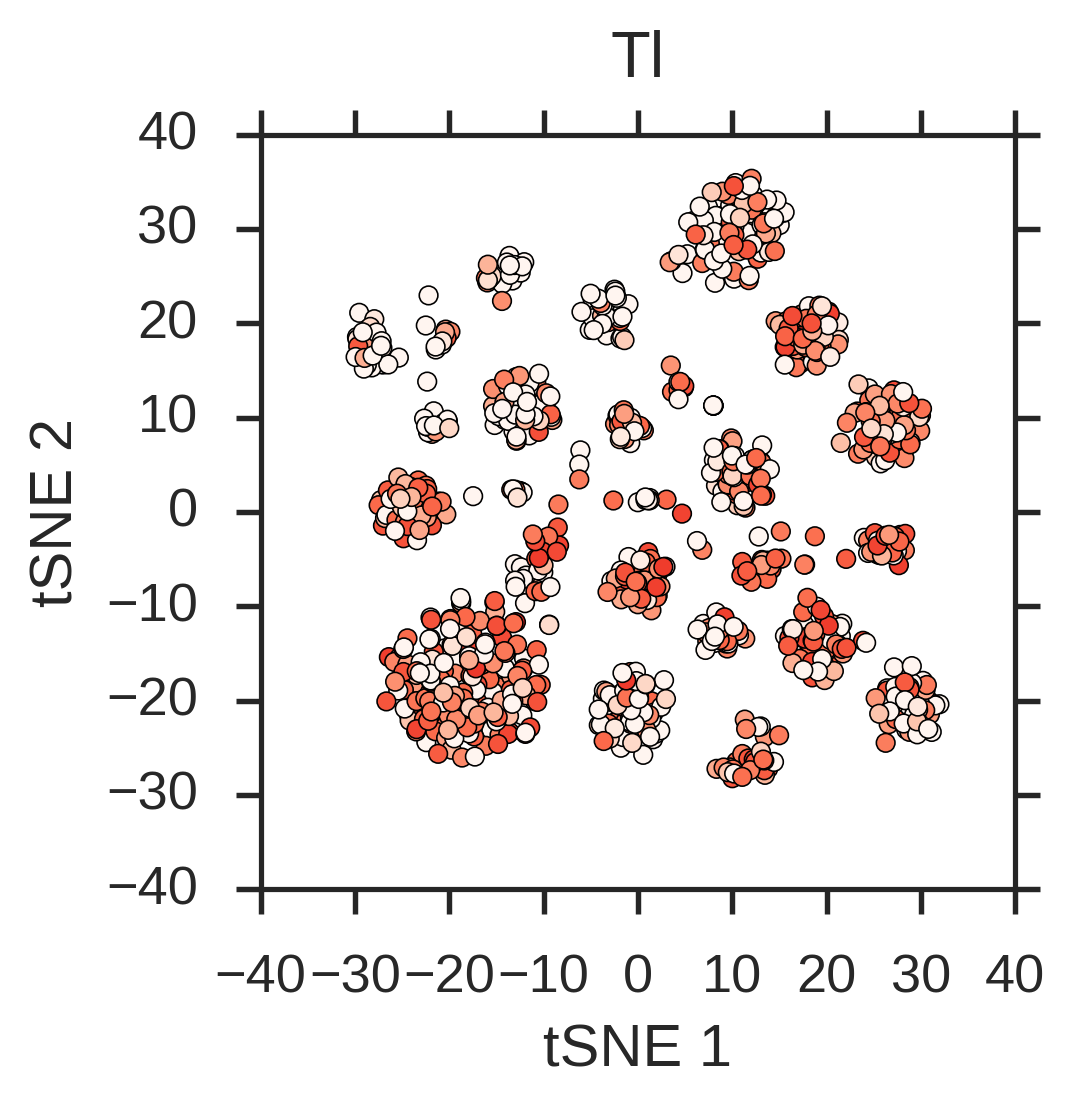

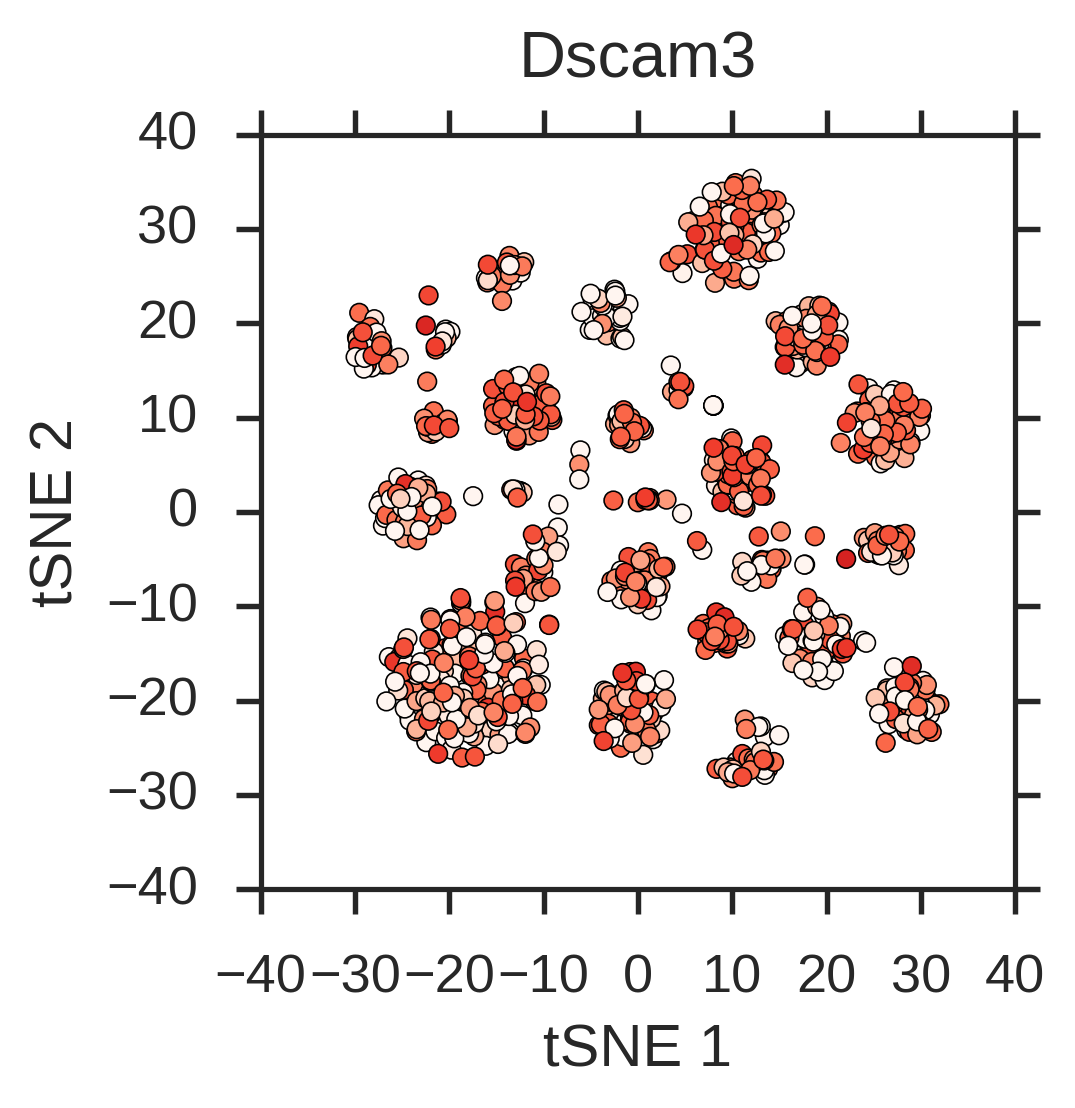

In [10]:
# Plot TSNE colored by expression levels
myGenes = ["acj6", "vvl", "fru", "CG31676", "CG45263", "trol", "pros", "ct", "mirr", "CG7358", "Tl", "Dscam3"]
for gene in myGenes:
    fig, ax = plt.subplots(1, 1, figsize=(6,4))
    myTSNE.plot(fig, ax, colorBy=gene, cmap="Reds")
    ax.set_title(gene, y=1.05)
    plt.tight_layout()

# Plot with colors from GH146 to identify DL3


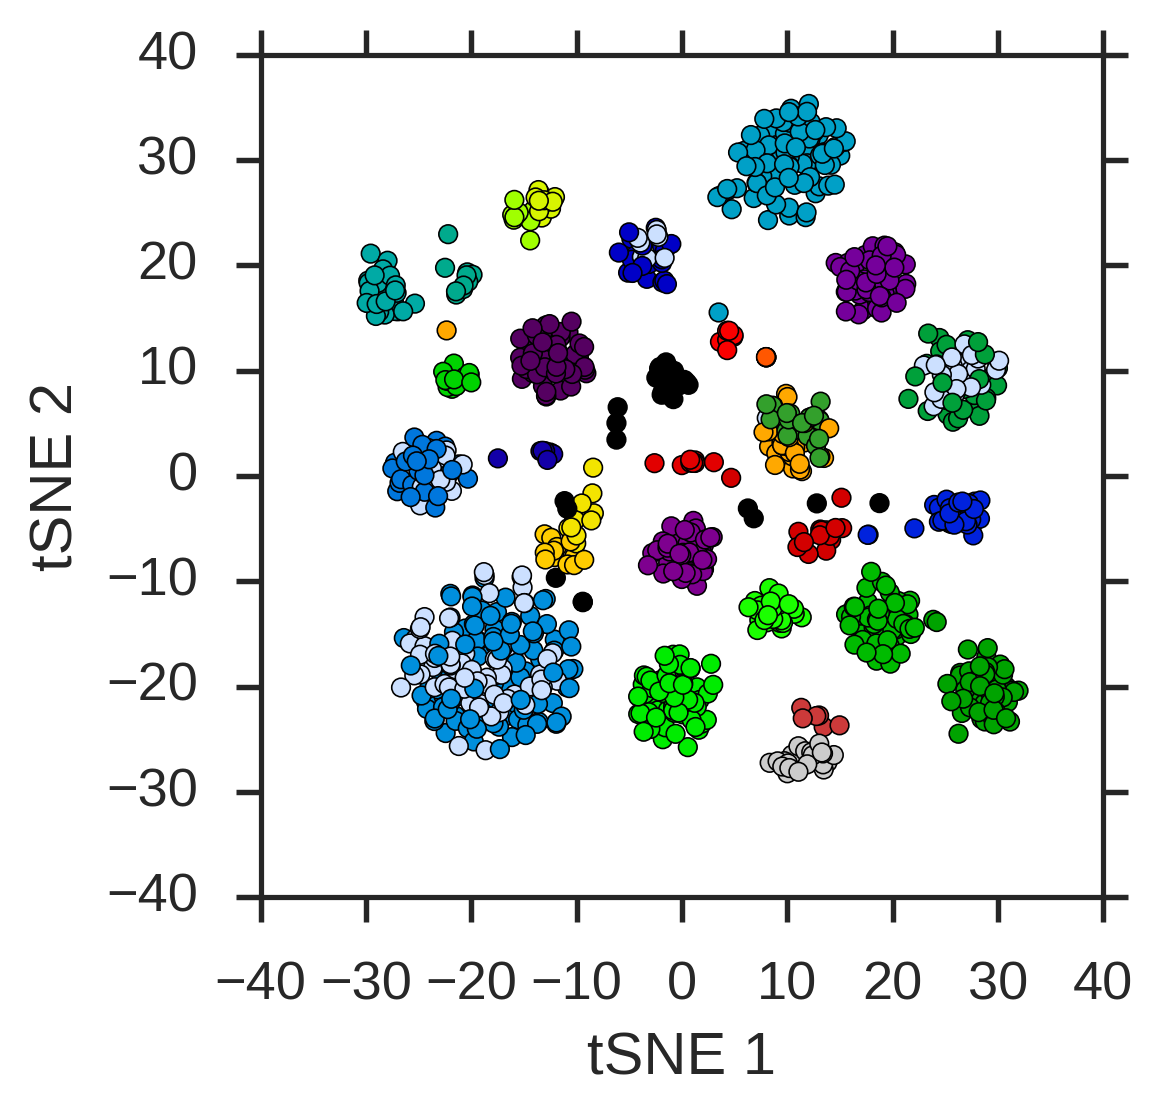

In [11]:
# Read labels
labels_HDBSCAN = pd.read_csv("../data/labels_HDBSCAN.csv", sep="\t", index_col=0, header=0)

# Set up custom colors (color )
cmap = plt.get_cmap("nipy_spectral", lut=max(labels_HDBSCAN.label))
my_colors = df_libs.loc[df.columns]["color"]
my_colors.loc[df_libs.loc[df.columns]["genotype"] == "GH146-GFP"] = [cmap(x) for x in labels_HDBSCAN.label]
my_colors.loc[df_libs.loc[df.columns]["genotype"] == "Mz19-GFP,24hAPF"] = df_libs.loc[df_libs["label"] == "Mz19-GFP,24hAPF"].color.iloc[0]
my_colors.loc[df_libs.loc[df.columns]["genotype"] == "91G04-GFP"] = df_libs.loc[df_libs["label"] == "91G04-GFP"].color.iloc[0]
my_colors.loc[df_libs.loc[df.columns]["genotype"] == "NP5103-GFP"] = df_libs.loc[df_libs["label"] == "NP5103-GFP"].color.iloc[0]

# Plot TSNE
fig, ax = plt.subplots(1, 1, figsize=(6,4))
myTSNE.plot(fig, ax, colorMode="custom", colorBy=my_colors, cmap="nipy_spectral")

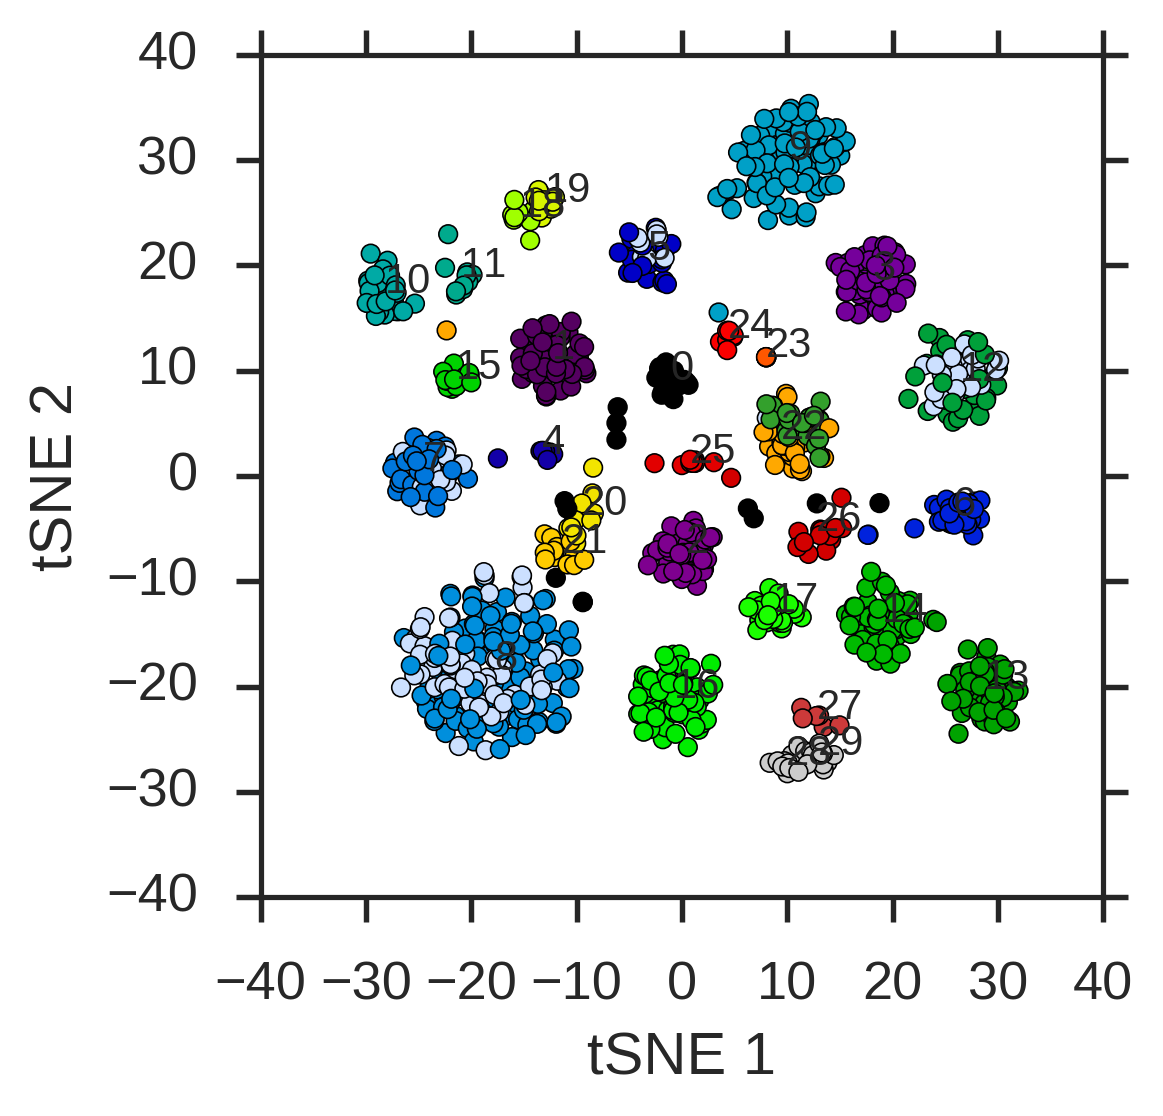

In [12]:
# Plot with labels

# Set up custom colors (color )
cmap = plt.get_cmap("nipy_spectral", lut=max(labels_HDBSCAN.label))
my_colors = df_libs.loc[df.columns]["color"]
my_colors.loc[df_libs.loc[df.columns]["genotype"] == "GH146-GFP"] = [cmap(x) for x in labels_HDBSCAN.label]
my_colors.loc[df_libs.loc[df.columns]["genotype"] == "Mz19-GFP,24hAPF"] = df_libs.loc[df_libs["label"] == "Mz19-GFP,24hAPF"].color.iloc[0]
my_colors.loc[df_libs.loc[df.columns]["genotype"] == "91G04-GFP"] = df_libs.loc[df_libs["label"] == "91G04-GFP"].color.iloc[0]
my_colors.loc[df_libs.loc[df.columns]["genotype"] == "NP5103-GFP"] = df_libs.loc[df_libs["label"] == "NP5103-GFP"].color.iloc[0]

# For plotting labels, subset TSNE coordinates to GH146
selector = np.array(df_libs.loc[df.columns]["genotype"] == "GH146-GFP")
myTSNE_X_tsne_GH146 = myTSNE.X_tsne[selector,:]

# Plot TSNE
fig, ax = plt.subplots(1, 1, figsize=(6,4))
myTSNE.plot(fig, ax, colorMode="custom", colorBy=my_colors, cmap="nipy_spectral")
for label in pd.Series(labels_HDBSCAN["label"]).value_counts().index:
    if label == -1: continue
    x_bar = np.mean(myTSNE_X_tsne_GH146[np.array(labels_HDBSCAN["label"] == label), 0])
    y_bar = np.mean(myTSNE_X_tsne_GH146[np.array(labels_HDBSCAN["label"] == label), 1])
    ax.text(x_bar, y_bar, label, size=10)